製圖：

In [ ]:
st = "SELECT%20`%E5%B9%B4%E6%9C%88%E6%97%A5`,`%E5%A0%B1%E9%85%AC%E7%8E%87%EF%BC%85`,`%E6%8A%95%E4%BF%A1%E8%B2%B7%E8%B3%A3%E8%B6%85(%E5%8D%83%E8%82%A1)`,`%E6%94%B6%E7%9B%A4%E5%83%B9(%E5%85%83)`,`%E9%96%8B%E7%9B%A4%E5%83%B9(%E5%85%83)`%20FROM%20`0051`%20WHERE%20`%E5%B9%B4%E6%9C%88%E6%97%A5`%20BETWEEN%20%272006-08-30%27%20AND%20%272023-08-30%27"
print(st)

SELECT%20`%E5%B9%B4%E6%9C%88%E6%97%A5`,`%E5%A0%B1%E9%85%AC%E7%8E%87%EF%BC%85`,`%E6%8A%95%E4%BF%A1%E8%B2%B7%E8%B3%A3%E8%B6%85(%E5%8D%83%E8%82%A1)`,`%E6%94%B6%E7%9B%A4%E5%83%B9(%E5%85%83)`,`%E9%96%8B%E7%9B%A4%E5%83%B9(%E5%85%83)`%20FROM%20`0051`%20WHERE%20`%E5%B9%B4%E6%9C%88%E6%97%A5`%20BETWEEN%20%272006-08-30%27%20AND%20%272023-08-30%27


In [258]:
try:
   # Code that may raise an exception
   x = 1 / 0
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: division by zero


In [280]:
x = np.array([0],dtype ='float64')
y = np.array([0],dtype ='float64')
# Create a NumPy array
my_array = np.array([1, 2, 2, 3, 5, 6, 7, 10])

# Append a single value to the end of the array
x = np.append(x, y)

print(x)
x.dtype == 'float64'

[0. 0.]


True

In [349]:
done = True
type(done) == bool

True

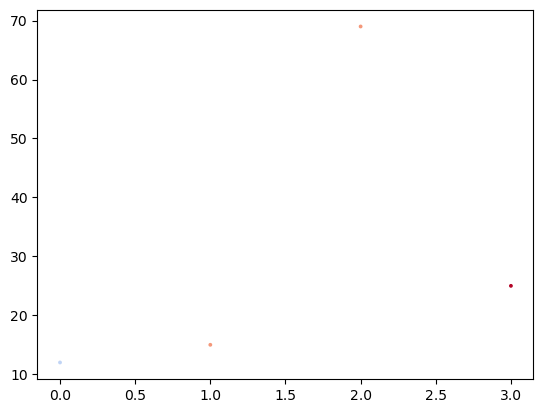

In [249]:
n_list = [0,1,2,3]
price_list = [12,15,69,25]
action_arr = [-0.2,0.5,0.5,1]
fig, ax = plt.subplots()
sc = ax.scatter(n_list, price_list, c=action_arr, cmap='coolwarm', vmin=-1, vmax=1, s=3)
sc

In [242]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.init import kaiming_uniform_

class ReplayBuffer(object):

    def __init__(self, max_size=1e6, seed=42):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0
        np.random.seed(seed)

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
        for i in ind: 
            state, next_state, action, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))
        return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)
    
class Actor(nn.Module):
  
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.lstm = nn.LSTM(input_size=state_dim[1], hidden_size=200, num_layers=1, batch_first=True)
        #self.layer_1 = nn.Linear(state_dim, 400)
        #self.ln1 = nn.LayerNorm(400)
        self.layer_2 = nn.Linear(200*state_dim[0], 300)
        self.ln2 = nn.LayerNorm(300)
        self.layer_3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.reshape(x.shape[0], -1)
        #x = F.relu(self.layer_1(x)) # Relu
        #x = self.ln1(x)
        x = F.relu(self.layer_2(x)) # Relu
        #x = self.ln2(x)
        x = nn.Tanh()(self.layer_3(x))
        return x
    
    def evaluate(self,x):
        x, _ = self.lstm(x.unsqueeze(0))
        x = x.flatten()
        #x = F.relu(self.layer_1(x)) # Relu
        #x = self.ln1(x)
        x = F.relu(self.layer_2(x)) # Relu
        #x = self.ln2(x)
        x = nn.Tanh()(self.layer_3(x))
        return x        
    
class Critic(nn.Module):
  
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Defining the first Critic neural network
        self.hidden_size = 200
        self.lstm = nn.LSTM(input_size=state_dim[1], hidden_size=self.hidden_size, num_layers=1, batch_first=False)
        self.layer_1 = nn.Linear(self.hidden_size*state_dim[0] + action_dim, 400)
        self.ln1 = nn.LayerNorm(400)
        self.layer_2 = nn.Linear(400, 300)
        self.ln2 = nn.LayerNorm(300)
        self.layer_3 = nn.Linear(300, 1)
        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(self.hidden_size*state_dim[0] + action_dim, 400)
        self.ln3 = nn.LayerNorm(400)
        self.layer_5 = nn.Linear(400, 300)
        self.ln4 = nn.LayerNorm(300)
        self.layer_6 = nn.Linear(300, 1)

        kaiming_uniform_(self.layer_1.weight)
        kaiming_uniform_(self.layer_2.weight)
        kaiming_uniform_(self.layer_3.weight)

        kaiming_uniform_(self.layer_4.weight) 
        kaiming_uniform_(self.layer_5.weight)
        kaiming_uniform_(self.layer_6.weight)

    def forward(self, x, u):
        x, _ = self.lstm(x)
        x = x.reshape(x.shape[0], -1)
        xu = torch.cat([x, u], 1)
        # Forward-Propagation on the first Critic Neural Network
        x1 = F.relu(self.layer_1(xu))
        #x1 = self.ln1(x1)
        x1 = F.relu(self.layer_2(x1))
        #x1 = self.ln2(x1)
        x1 = self.layer_3(x1)
        # Forward-Propagation on the second Critic Neural Network
        x2 = F.relu(self.layer_4(xu))
        #x2 = self.ln3(x2)
        x2 = F.relu(self.layer_5(x2))
        #x2 = self.ln4(x2)
        x2 = self.layer_6(x2)
        return x1, x2

    def Q1(self, x, u):
        x, _ = self.lstm(x)
        x = x.reshape(x.shape[0], -1)
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1
    
class TD3(object):
  
    def __init__(self, state_dim, action_dim, max_action,seed):
        torch.manual_seed(seed)
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=1e-5, weight_decay=2)
        
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=1e-4,weight_decay=1)

        self.max_action = max_action

    def evaluate_action(self, state):
        #state = torch.Tensor(state.reshape(1, -1)).to(device)
        state = torch.Tensor(state).to(device)
        return self.actor.evaluate(state).cpu().data.numpy().flatten()

    def select_action(self, state):
        #state = torch.Tensor(state.reshape(1, -1)).to(device)
        state = torch.Tensor(state).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):
            
            # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.Tensor(batch_states).to(device)
            next_state = torch.Tensor(batch_next_states).to(device)
            action = torch.Tensor(batch_actions).to(device)
            reward = torch.Tensor(batch_rewards).to(device)
            done = torch.Tensor(batch_dones).to(device)

            # Step 5: From the next state s’, the Actor target plays the next action a’
            next_action = self.actor_target(next_state)
            
            # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
            noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
            
            
            # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)

            # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
            target_Q = torch.min(target_Q1, target_Q2)

            # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
            target_Q = reward + ((1 - done) * discount * target_Q).detach()
            
            # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
            current_Q1, current_Q2 = self.critic(state, action)
            
            # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
            
            # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean() # self.actor(state) -> action actor_loss -> score of the action
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                #print(self.actor(state))
                #print(self.critic(state, action))
                #for name, param in self.actor.named_parameters():
                #    if 'weight' in name:
                #        print(name, param)
                # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

state_dim = (10,12)
action_dim = 1
max_action = 1.0
file_name = 'TD3_Guest_jim'
policy = TD3(state_dim, action_dim, max_action,42)
policy.load(file_name, '../Model_Repository/pytorch_models')

In [244]:
for name, param in policy.actor.named_parameters():
    if 'weight' in name:
        print(name,param.shape, param)

lstm.weight_ih_l0 torch.Size([800, 12]) Parameter containing:
tensor([[-1.9283e-13, -6.3785e-13,  9.8930e-11,  ..., -4.8004e-12,
         -5.5577e-12, -1.5846e-08],
        [-3.5189e-13, -3.9930e-12,  8.3874e-09,  ..., -1.3653e-12,
          8.7521e-14,  9.1284e-15],
        [ 5.3833e-13, -4.4735e-14, -2.4870e-07,  ..., -2.1879e-08,
          6.7659e-11,  2.3179e-11],
        ...,
        [-5.3729e-11, -5.2604e-14,  3.9876e-13,  ...,  4.1020e-12,
         -1.5337e-12,  3.9219e-13],
        [-5.0701e-11, -1.4255e-11, -1.9904e-12,  ..., -3.0473e-13,
          1.5771e-13,  4.4852e-08],
        [ 3.4537e-13,  2.0049e-09,  6.9635e-10,  ..., -4.1343e-09,
         -1.3403e-10,  2.9617e-11]], device='cuda:0', requires_grad=True)
lstm.weight_hh_l0 torch.Size([800, 200]) Parameter containing:
tensor([[ 1.5746e-13, -3.5927e-12, -2.3079e-10,  ..., -6.3944e-15,
         -1.1707e-12,  4.4198e-11],
        [ 6.9120e-15,  6.8618e-12, -1.2445e-10,  ..., -2.1100e-09,
          9.6820e-15,  1.2886e-07],


In [232]:
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(YourModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(4000, 1)  # 输出一个值

    def forward(self, x):
        
        last_output, _ = self.lstm(x)
        last_output = last_output.reshape(100, -1)
        # 获取序列的最后一个时间步的输出
        #last_output = lstm_out[:, -1, :]
        print(last_output.shape)
        
        # 通过全连接层映射到单一值
        output = self.fc(last_output)
        
        print(output.shape)
        return output

# 创建模型
input_size = 12  # 你的特征数
hidden_size = 400
model = YourModel(input_size, hidden_size)

# 示例输入
example_input = torch.randn(100,10, 12) 

# 调用模型
output = model(example_input)
print(output)


torch.Size([100, 4000])
torch.Size([100, 1])
tensor([[-0.0039],
        [-0.0032],
        [ 0.0010],
        [-0.0054],
        [ 0.0056],
        [-0.0331],
        [ 0.0093],
        [-0.0037],
        [ 0.0136],
        [-0.0196],
        [-0.0051],
        [ 0.0285],
        [-0.0176],
        [-0.0111],
        [-0.0118],
        [ 0.0022],
        [-0.0166],
        [-0.0131],
        [-0.0117],
        [-0.0089],
        [ 0.0321],
        [ 0.0063],
        [-0.0114],
        [-0.0216],
        [ 0.0264],
        [-0.0090],
        [-0.0064],
        [-0.0257],
        [ 0.0096],
        [-0.0168],
        [-0.0221],
        [ 0.0532],
        [-0.0051],
        [ 0.0183],
        [-0.0006],
        [-0.0228],
        [-0.0301],
        [ 0.0289],
        [-0.0226],
        [ 0.0146],
        [-0.0061],
        [-0.0196],
        [ 0.0018],
        [-0.0157],
        [-0.0146],
        [-0.0144],
        [-0.0261],
        [ 0.0163],
        [ 0.0399],
        [-0.0136],
     

In [223]:
 torch.randn(100,10, 12).shape

torch.Size([100, 10, 12])

In [112]:
import numpy as np

# 假设你的数据是标量值
scalar_value = 1712.0

# 将标量值转换为2D数组
array_2d = np.array(scalar_value).reshape(1, -1)
array_2d[0][0]

1712.0

In [172]:
x = np.array([[5,6,7],[8,9,10],[11,12,13]], dtype ='float64')
print(type(x),np.max(x))
x[0:2,1] = 5
x

<class 'numpy.ndarray'> 13.0


array([[ 5.,  5.,  7.],
       [ 8.,  5., 10.],
       [11., 12., 13.]])

Text(0.5, 1.0, 'Sample Plot')

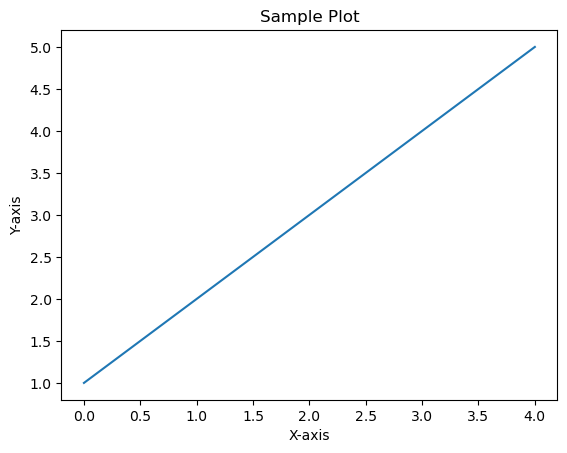

In [13]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# 创建一个示例图表
fig = plt.figure()
plt.plot([1, 2, 3, 4, 5])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sample Plot')

In [46]:
query = "SELECT `performance` FROM `Agent_data` WHERE `Account` = 'Guest' AND`Agent` = 'hi'" 
result = engine.execute(query)
performance_b = result.fetchall()[0][0]
performance_b

In [15]:
fig.savefig("./sample_plot.png")

In [32]:
import requests
from bs4 import BeautifulSoup
import re
yesterday = '2023-10-19'
cur_code = '0050'
data_link = f'https://tw.stock.yahoo.com/quote/'+ cur_code +'.TW/institutional-trading'
res = requests.get(url=data_link)
soup = BeautifulSoup(res.text,'html.parser')

done = False
info = soup.find_all("div",string=re.compile(str(yesterday).replace('-','/')))[0].find_parents("li")
done = True
stock_info = info[0].find_all("span",class_="Jc(fe)")
stock_info

[<span class="Jc(fe)">-431</span>,
 <span class="Jc(fe)">225</span>,
 <span class="Jc(fe)">3,729</span>,
 <span class="Jc(fe) D(f) Ai(c) C($c-trend-up)">3,523</span>,
 <span class="Jc(fe)">2.93%</span>,
 <span class="Fw(600) Jc(fe) D(f) Ai(c) C($c-trend-up)"><span class="Mend(4px) Bds(s)" style="border-color:transparent transparent #ff333a transparent;border-width:0 5px 7px 5px"></span>0.04%</span>,
 <span class="Jc(fe)">7,816</span>]

cuda is on


C:\Users\julia\.conda\envs\SALL_Agency\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


0.013731, 


---------------------------------------
Average Reward over the Evaluation Step: 8.348547
---------------------------------------
Total Timesteps: 100 Episode Num: 1 Reward: 3.203136787278965
Total Timesteps: 200 Episode Num: 2 Reward: 306.37518802242806
Total Timesteps: 300 Episode Num: 3 Reward: 28.8124688035806
Total Timesteps: 400 Episode Num: 4 Reward: -943.2726609189392
Total Timesteps: 500 Episode Num: 5 Reward: -1108.2266507777572
Total Timesteps: 600 Episode Num: 6 Reward: -185.751027314457
Total Timesteps: 700 Episode Num: 7 Reward: 213.85712686696635
Total Timesteps: 800 Episode Num: 8 Reward: -111.32834999536905
Total Timesteps: 900 Episode Num: 9 Reward: 9.038383392776693
Total Timesteps: 1000 Episode Num: 10 Reward: 136.92119757111246
Total Timesteps: 1100 Episode Num: 11 Reward: 19.028464070715913
Total Timesteps: 1200 Episode Num: 12 Reward: 68.27619672313968
Total Timesteps: 1300 Episode Num: 13 Reward: 7.210888134284794
Total Timesteps: 1400 Episode Num: 

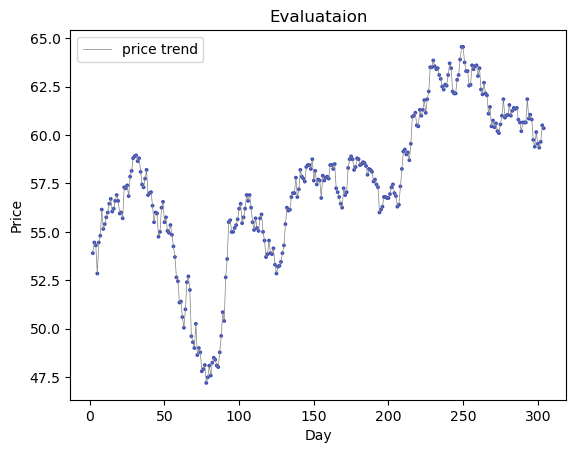

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


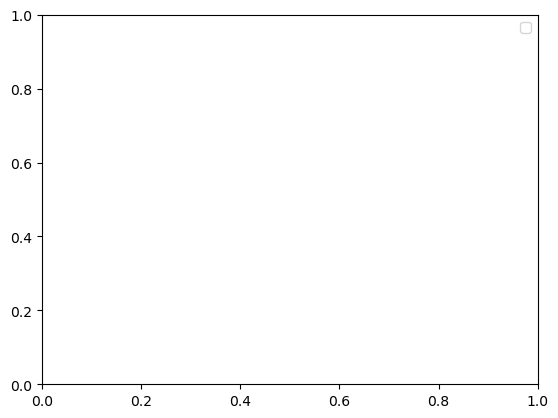

In [1]:
import DDPG_TD3_Training
evaluation_uri = DDPG_TD3_Training.Train()

In [30]:
df = pd.DataFrame(columns=['Code'],dtype=float)

In [31]:
df.to_csv("../File_repository/Unsuccess.csv", encoding="utf_8_sig", index= False)

,Site,Age


In [41]:
unsuccess = pd.read_csv('../File_Repository/Unsuccess.csv')
unsuccess.drop_duplicates(keep=False)

,Code


In [111]:
list(set(unsuccess['Code'][:69]))

['01009T',
 '2838A',
 '2836A',
 '02001R',
 '020037',
 '3702A',
 '02001S',
 '020028',
 '020022',
 '3036A',
 '2882B',
 '01007T',
 '2891B',
 '8112A',
 '020032',
 '2887Z1',
 '020002',
 '00636K',
 '1312A',
 '2002A',
 '2348A',
 '2887F',
 '2882A',
 '2888A',
 '01010T',
 '020007',
 '020012',
 '02001L',
 '020031',
 '2881C',
 '020019',
 '020029',
 '020030',
 '00625K',
 '020016',
 '2881B',
 '01002T',
 '01003T',
 '9941A',
 '2891C',
 '00668K',
 '1522A',
 '00657K',
 '5871A',
 '020011',
 '2883B',
 '020036',
 '2897A',
 '020018',
 '2887E',
 '020038',
 '01004T',
 '1101B',
 '020020',
 '00643K',
 '2881A',
 '6592A',
 '020000',
 '2888B',
 '020034',
 '01001T',
 '020015']

In [104]:
code_data = pd.read_csv('../File_Repository/stock/名稱對照.csv')

In [105]:
for i in range(len(unsuccess[:69])):
    try:
        idx=code_data[code_data["Code"]==unsuccess["Code"][i]].index[0]
        code_data = code_data.drop(idx)
    except:
        pass
code_data

,Code,Name
0,0050,元大台灣50
1,0051,元大中型100
2,0052,富邦科技
3,0053,元大電子
4,0055,元大MSCI金融
...,...,...
1194,9944,新麗
1195,9945,潤泰新
1196,9946,三發地產
1197,9955,佳龍


In [110]:
code_data.to_csv('../File_Repository/stock/名稱對照.csv', encoding="utf_8_sig", index= False)

In [82]:
unsuccess["Code"][26]

'01001T'

In [30]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, Date, Integer, String, ForeignKey

DATABASE = {
'host': 'localhost',
'port': '8989',
'database': 'AP',
'user': 'root',
'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                    .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                    , echo=False)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, Date, Integer, String, ForeignKey

DATABASE = {
'host': 'localhost',
'port': '8989',
'database': 'stock_data',
'user': 'root',
'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                    .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                    , echo=False)


#连接数据表
query = "SELECT `年月日`,`開盤價(元)`,`報酬率％`,`週轉率％`,`成交筆數(筆)`,`本益比-TSE` FROM `0055` WHERE `年月日` BETWEEN '2007-07-13' AND '2023-08-30'"
result = engine.execute(query)
df = pd.DataFrame(result.fetchall(),columns=list(result.keys()))
df

,年月日,開盤價(元),報酬率％,週轉率％,成交筆數(筆),本益比-TSE
0,2007/07/13,NaN,NaN,NaN,NaN,NaN
1,2007/07/16,16.08,1.0572,10.6349,1089.0,0.0
2,2007/07/17,16.50,0.7385,14.3606,1847.0,0.0
3,2007/07/18,16.35,1.1607,10.4315,1541.0,0.0
4,2007/07/19,16.60,-1.5700,5.2801,944.0,0.0
...,...,...,...,...,...,...
3814,2022/12/26,21.60,0.1392,0.2525,330.0,NaN
3815,2022/12/27,21.62,0.1854,0.2525,215.0,NaN
3816,2022/12/28,21.69,-0.4163,0.1401,183.0,NaN
3817,2022/12/29,21.50,-0.8360,0.1256,268.0,NaN


In [39]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, Date, Integer, String, ForeignKey

DATABASE = {
'host': 'localhost',
'port': '8989',
'database': 'AP',
'user': 'root',
'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                    .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                    , echo=False)


#连接数据表
account ='Guest'
agent_name='test'
query = "SELECT `買賣價`,`seed`,`reward_driver`,`punish_driver`,`length`,`stock_amount`,`interest_rate`,`fee_rate`,`invest_budget` FROM `Agent_data` WHERE `Account` = '"+ account +"' AND`Agent` = '" + agent_name + "'"
result = engine.execute(query)
result.fetchall()[0][8]


TypeError: float() argument must be a string or a number, not 'NoneType'

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, Date, Integer, String, ForeignKey

DATABASE = {
'host': 'localhost',
'port': '8989',
'database': 'stock_data',
'user': 'root',
'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                    .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                    , echo=False)


#连接数据表
query = "SELECT `收盤價(元)` FROM `0050`  ORDER BY `年月日` DESC LIMIT 0 , 1"
result = engine.execute(query)
result.fetchall()[0][0]

125.9

In [ ]:
len(df)

3819

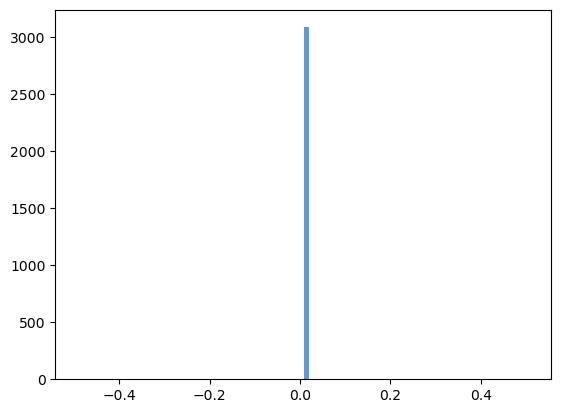

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
arr = df['本益比-TSE'].fillna('').tolist()
arr = list(filter(lambda x: x != '', arr))
hist,bin_edges = np.histogram(arr,bins=70)
plt.bar(bin_edges[1:],hist,color='#5B9BD5',width=(bin_edges[3]-bin_edges[2]) / 0.87 * 0.7 )
plt.show()

In [ ]:
df['合計買賣超(千股)'].isna().sum()

1

In [ ]:
column = df['合計買賣超(千股)']
column[column == 0].count()

288

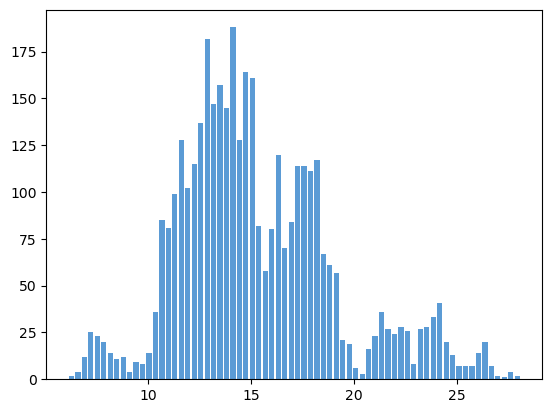

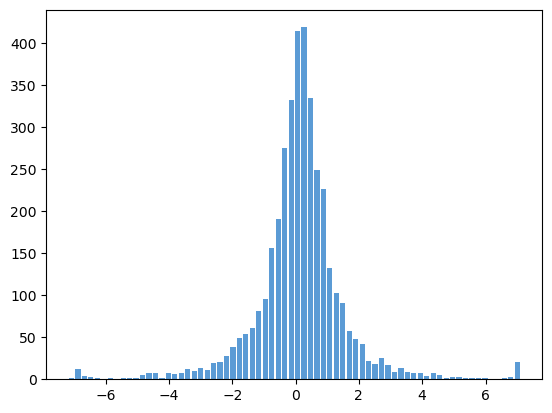

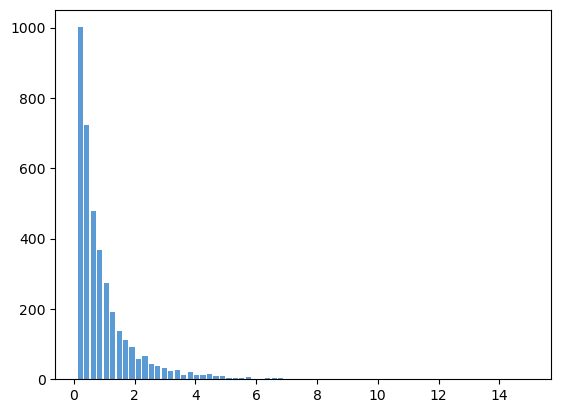

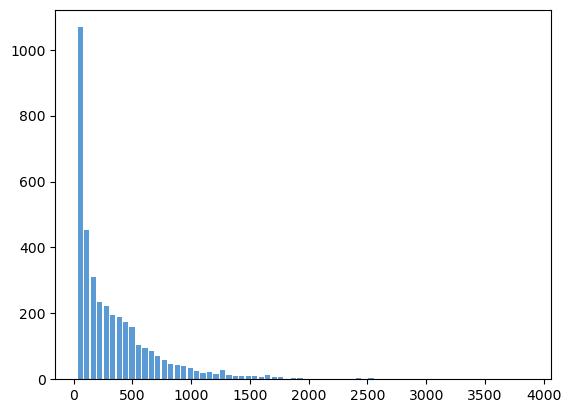

TypeError: cannot perform reduce with flexible type

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import io
import base64

baseket ={}

for name in list(result.keys()):
    if name == '年月日':continue
    fig=plt.figure()
    baseket[name+'_N'] = df[name].isna().sum()
    column = df[name]
    baseket[name+'_Z'] = column[column == 0].count()
    arr = df[name].fillna('').tolist()
    arr.remove('')
    hist,bin_edges = np.histogram(arr,bins=70)
    plt.bar(bin_edges[1:],hist,color='#5B9BD5',width=(bin_edges[3]-bin_edges[2]) / 0.87 * 0.7 )
    pic_IObytes = io.BytesIO()
    #plt.savefig(loss_chart_path)
    plt.savefig(pic_IObytes,  format='png')
    plt.show()
    plt.close(fig)
    pic_IObytes.seek(0)
    pic_hash = base64.b64encode(pic_IObytes.read())
    new_encoded = str(pic_hash)
    new_encoded = new_encoded[2:-1]
    baseket[name] = 'data:image/png;base64,{}'.format(new_encoded)

In [ ]:
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

def MACD():
    prices = list_input[:,0]
    ema_short = calculate_ema(prices, 12)
    ema_long = calculate_ema(prices, 26)
    len(ema_short)
    dif = []
    for i in range(0,len(prices)-len(ema_short)):
        tmp = ema_short[i]
        ema_short.insert( i, tmp)

    for j in range(0,len(prices)-len(ema_long)):
        tmp = ema_long[i]
        ema_long.insert( i, tmp)

    for k in range(0,len(prices)):
        dif.append(ema_short[k] - ema_long[k])

    MACD = calculate_ema(dif, 9)
    for j in range(0,len(prices)-len(MACD)):
        tmp = MACD[i]
        MACD.insert( i, tmp)

    MACD_arr = np.array(MACD).reshape(len(MACD),1)
    list_input = np.hstack((list_input,MACD_arr))
    return list_input

In [18]:
import pandas as pd
import requests
import time
from fake_useragent import UserAgent
import json
from bs4 import BeautifulSoup
import datetime
import re
user_agent = UserAgent()

In [19]:
symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()
price_code = []
for i in range(len(data)):
    price_code.append(data[i]["Code"])
data[300]

{'Code': '1522',
 'Name': '堤維西',
 'TradeVolume': '5037170',
 'TradeValue': '192034032',
 'OpeningPrice': '38.55',
 'HighestPrice': '39.60',
 'LowestPrice': '37.40',
 'ClosingPrice': '37.40',
 'Change': '-1.1500',
 'Transaction': '2925'}

In [23]:
price_index = price_code.index('6854')
num_index = num_code.index('6854')
round(float(data[price_index]['TradeVolume'].replace(',',''))/(float(data_num[num_index]['實收資本額'])/10)*100,4)

ValueError: could not convert string to float: 

In [24]:
data[price_index]['TradeVolume'].replace(',','')

''

In [21]:
num_link = f'https://openapi.twse.com.tw/v1/opendata/t187ap03_L'
res_num = requests.get(url=num_link)
data_num = res_num.json()
num_code = []
for i in range(len(data_num)):
    num_code.append(data_num[i]["公司代號"])
data_num[0]

{'出表日期': '1121031',
 '公司代號': '1101',
 '公司名稱': '臺灣水泥股份有限公司',
 '公司簡稱': '台泥',
 '外國企業註冊地國': '－ ',
 '產業別': '01',
 '住址': '台北市中山北路2段113號',
 '營利事業統一編號': '11913502',
 '董事長': '張安平',
 '總經理': '程耀輝',
 '發言人': '葉毓君',
 '發言人職稱': '永續長',
 '代理發言人': '賴家柔',
 '總機電話': '(02)2531-7099',
 '成立日期': '19501229',
 '上市日期': '19620209',
 '普通股每股面額': '新台幣                 10.0000元',
 '實收資本額': '73561817420',
 '私募股數': '0',
 '特別股': '200000000',
 '編制財務報表類型': '1',
 '股票過戶機構': '中國信託商業銀行代理部',
 '過戶電話': '66365566',
 '過戶地址': '台北市重慶南路一段83號5樓',
 '簽證會計師事務所': '勤業眾信聯合會計師事務所',
 '簽證會計師1': '翁雅玲',
 '簽證會計師2': '黃惠敏',
 '英文簡稱': 'TCC',
 '英文通訊地址': 'No.113, Sec.2, Zhongshan N. Rd.,Taipei City 104,Taiwan (R.O.C.)',
 '傳真機號碼': '(02)2531-6529',
 '電子郵件信箱': 'finance@taiwancement.com',
 '網址': 'http://www.taiwancement.com',
 '已發行普通股數或TDR原股發行股數': '7156181742'}

In [ ]:
symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/FMTQIK'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()

In [ ]:
symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()
price_code = []
for i in range(len(data)):
    price_code.append(data[i]["Code"])

dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/資料庫/名稱對照.csv', dtype={'Code':str})
need_del = list(set(code_1).difference(set(price_code)))
for c in need_del:
    dataset = dataset.drop(dataset[dataset.Code == c].index)
dataset.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/資料庫/名稱對照.csv", encoding="utf_8_sig", index= False)

In [ ]:
symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()
price_code = []
for i in range(len(data)):
    price_code.append(data[i]["Code"])
len(data)

1199

In [ ]:
data_link = f'https://openapi.twse.com.tw/v1/exchangeReport/MI_MARGN'
res = requests.get(url=data_link)
data = res.json()
loan_code = []
for i in range(len(data)):
    loan_code.append(data[i]["股票代號"])
data[2]

{'股票代號': '0052',
 '股票名稱': '富邦科技',
 '融資買進': '3',
 '融資賣出': '1',
 '融資現金償還': '',
 '融資前日餘額': '53',
 '融資今日餘額': '55',
 '融資限額': '11000',
 '融券買進': '',
 '融券賣出': '',
 '融券現券償還': '',
 '融券前日餘額': '',
 '融券今日餘額': '',
 '融券限額': '11000',
 '資券互抵': '',
 '註記': ' '}

In [ ]:
data_link = f'https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_ALL'
res = requests.get(url=data_link)
data = res.json()
gain_code = []
for i in range(len(data)):
    gain_code.append(data[i]["Code"])
data[0]

{'Code': '1101',
 'Name': '台泥',
 'PEratio': '28.81',
 'DividendYield': '1.42',
 'PBratio': '1.20'}

In [126]:
def stock_num(code):

    try:
        data_link = f'https://www.moneydj.com/etf/x/basic/basic0003.xdjhtm?etfid='+ code +'.tw'
        res = requests.get(url=data_link, headers={"User-Agent": user_agent.random})
        soup = BeautifulSoup(res.text,'html.parser')
        num_text = soup.find_all("td" ,class_="col02")[1].string
        num = re.findall(r'\d+', num_text)
        eq = float(num[0] + '.' + num[1])

        data_link = f'https://tw.stock.yahoo.com/quote/'+code+'.TW/profile'
        res = requests.get(url=data_link, headers={"User-Agent": user_agent.random})
        asset = float(res.text.split('資產規模')[1].split('</div>')[0].rsplit('>')[-1].replace(',',''))

        return int(asset/eq*1e6)
    except:
        if(code == '0055' or code == '0056'):
            return stock_num(code)
        print("此股票無資料： ",code)
        return False

In [128]:
stock_num('00684R')

7657945

In [ ]:
num_link = f'https://openapi.twse.com.tw/v1/opendata/t187ap03_L'
res_num = requests.get(url=num_link)
data_num = res_num.json()
num_code = []
for i in range(len(data_num)):
    num_code.append(data_num[i]["公司代號"])
data_num[0]

{'出表日期': '1120821',
 '公司代號': '1101',
 '公司名稱': '臺灣水泥股份有限公司',
 '公司簡稱': '台泥',
 '外國企業註冊地國': '－ ',
 '產業別': '01',
 '住址': '台北市中山北路2段113號',
 '營利事業統一編號': '11913502',
 '董事長': '張安平',
 '總經理': '程耀輝',
 '發言人': '葉毓君',
 '發言人職稱': '永續長',
 '代理發言人': '賴家柔',
 '總機電話': '(02)2531-7099',
 '成立日期': '19501229',
 '上市日期': '19620209',
 '普通股每股面額': '新台幣                 10.0000元',
 '實收資本額': '73561817420',
 '私募股數': '0',
 '特別股': '200000000',
 '編制財務報表類型': '1',
 '股票過戶機構': '中國信託商業銀行代理部',
 '過戶電話': '66365566',
 '過戶地址': '台北市重慶南路一段83號5樓',
 '簽證會計師事務所': '勤業眾信聯合會計師事務所',
 '簽證會計師1': '翁雅玲',
 '簽證會計師2': '黃惠敏',
 '英文簡稱': 'TCC',
 '英文通訊地址': 'No.113, Sec.2, Zhongshan N. Rd.,Taipei City 104,Taiwan (R.O.C.)',
 '傳真機號碼': '(02)2531-6529',
 '電子郵件信箱': 'finance@taiwancement.com',
 '網址': 'http://www.taiwancement.com',
 '已發行普通股數或TDR原股發行股數': '7156181742'}

In [ ]:
data_link = f'https://openapi.twse.com.tw/v1/opendata/t187ap47_L'
res = requests.get(url=data_link)
data = res.json()
data[0]

{'基金名稱': '1120818',
 '標的指數/追蹤指數名稱': '0050',
 '備註': '元大台灣卓越50證券投資信託基金',
 '出表日期': '臺灣50指數',
 '過戶地址': '(02)2717-5555',
 '地址': '國內成分證券指數股票型基金',
 '英文名稱': 'Yuanta/P-shares Taiwan Top 50 ETF',
 '基金類型': '臺北市大安區敦化南路二段69號18樓及67號地下一層',
 '過戶機構': '劉宗聖',
 '總代理人': '林瑞源(代理)',
 '總機': '謝忠賢',
 '發言人': '林瑞源',
 '總經理': '陳重銓',
 '董事長': '98764389',
 '投資經理人': '',
 '代理發言人': '0920630',
 '發行單位數/轉換數': '0920625',
 '過戶電話': '2433500000',
 '基金代號': '臺灣集中保管結算所股份有限公司',
 '統一編號': '(02)2719-5805',
 '上市日期': '台北市復興北路363號11樓',
 '成立日期': '否',
 '指數股票型基金(ETF)之標的指數是否包含外國成份股': ''}

In [ ]:
data_link = f'https://tw.stock.yahoo.com/quote/0050.TW/institutional-trading'
res = requests.get(url=data_link, headers={
    "User-Agent": user_agent.random
})
soup = BeautifulSoup(res.text,'html.parser')

In [ ]:
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
soup.find_all("div",string=re.compile(str(yesterday).replace('-','/')))[0].find_parents("li")

[<li class="List(n)"><div class="Bgc(#fff) table-row D(f) Ai(c) Bgc(#e7f3ff):h Fz(16px) Px(12px) Bxz(bb) Bdbs(s) Bdbw(1px) Bdbc($bd-primary-divider) H(40px)" style="padding:0 12px 0 0"><div class="D(f) Start(0) H(100%) Ai(c) Bgc(#fff) table-row:h_Bgc(#e7f3ff) Pstart(12px) Pend(12px) Bdrststart(4px) Bdrsbstart(4px) Pos(r) Bxz(bb) Z(2)" style="position:sticky;min-width:96px"><div class="W(96px) Ta(start)">2023/08/18</div></div><div class="Fxg(1) Fxs(1) Fxb(0%) Miw($w-table-cell-min-width) Ta(end) Mend($m-table-cell-space) Mend(0):lc"><span class="Jc(fe)">-4,915</span></div><div class="Fxg(1) Fxs(1) Fxb(0%) Miw($w-table-cell-min-width) Ta(end) Mend($m-table-cell-space) Mend(0):lc"><span class="Jc(fe)">0</span></div><div class="Fxg(1) Fxs(1) Fxb(0%) Miw($w-table-cell-min-width) Ta(end) Mend($m-table-cell-space) Mend(0):lc"><span class="Jc(fe)">-207</span></div><div class="Fxg(1) Fxs(1) Fxb(0%) Miw($w-table-cell-min-width) Ta(end) Mend($m-table-cell-space) Mend(0):lc"><span class="Jc(fe) D(

In [ ]:
info = soup.find_all("div",string=re.compile(str(yesterday).replace('-','/')))[0].find_parents("li")
big3 = ["外資","投信","自營商","合計","外資籌碼","漲跌幅","法人成交量"]
big3_baseket={}
for i in range(0,7):
    big3_baseket[big3[i]] = info[0].find_all("span",class_="Jc(fe)")[i].text

big3_baseket

{'外資': '-5,553',
 '投信': '100',
 '自營商': '919',
 '合計': '-4,534',
 '外資籌碼': '10.75%',
 '漲跌幅': '0.44%',
 '成交量': '9,623'}

In [ ]:
len(info[0].find_all("span",class_="Jc(fe)"))

6

In [ ]:
def daily_collect(start,end):

    # 股價資料
    price_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
    price_res = requests.get(url=price_link)
    price_data = price_res.json()
    price_code = []
    for i in range(len(price_data)):
        price_code.append(price_data[i]["Code"])

    # 融資資料
    loan_link = f'https://openapi.twse.com.tw/v1/exchangeReport/MI_MARGN'
    loan_res = requests.get(url=loan_link)
    loan_data = loan_res.json()
    loan_code = []
    for i in range(len(loan_data)):
        loan_code.append(loan_data[i]["股票代號"])

    # 本益比、殖利率及股價淨值比 資料
    gain_link = f'https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_ALL'
    gain_res = requests.get(url=gain_link)
    gain_data = gain_res.json()
    gain_code = []
    for i in range(len(gain_data)):
        gain_code.append(gain_data[i]["Code"])

    # 週轉率
    num_link = f'https://openapi.twse.com.tw/v1/opendata/t187ap03_L'
    res_num = requests.get(url=num_link)
    data_num = res_num.json()
    num_code = []
    for i in range(len(data_num)):
        num_code.append(data_num[i]["公司代號"])

    # 三大法人
    today = datetime.date.today()
    yesterday = today - datetime.timedelta(days = 1)
    stock_baseket = {}
    for i in range(start,end):

        #print('\r 目前正在蒐集 '+ price_data[i]['Code'] +' 的資料，已完成了: ' +str(i+1) +'/'+ str(len(price_code))+' 個',end='',flush=True)
        # 三大法人
        data_link = f'https://tw.stock.yahoo.com/quote/'+ price_data[i]['Code'] +'.TW/institutional-trading'
        res = requests.get(url=data_link)
        soup = BeautifulSoup(res.text,'html.parser')

        stop = 0
        done = False
        while(not done):
            try:
                info = soup.find_all("div",string=re.compile(str(yesterday).replace('-','/')))[0].find_parents("li")
                done = True
            except:
                yesterday = yesterday - datetime.timedelta(days = 1)
                stop+=1
                if(stop>5):done = True
        if(stop >5):continue
        big3 = ["外資","投信","自營商","合計","外資籌碼","漲跌幅","成交量"]
        big3_baseket={}
        for k in range(0,7):
            stock_info = info[0].find_all("span",class_="Jc(fe)")
            if(len(stock_info) == 6 and k == 4):
                big3_baseket[big3[5]] = info[0].find_all("span",class_="Jc(fe)")[4].text
                big3_baseket[big3[6]] = info[0].find_all("span",class_="Jc(fe)")[5].text
                break
            big3_baseket[big3[k]] = info[0].find_all("span",class_="Jc(fe)")[k].text

        try:
            loan_index = loan_code.index(price_code[i])
            l_b = float(loan_data[loan_index]['融資買進']) if loan_data[loan_index]['融資買進']!='' else 0
            l_s = float(loan_data[loan_index]['融資賣出']) if loan_data[loan_index]['融資賣出']!='' else 0
            l_l = float(loan_data[loan_index]['融資今日餘額']) if loan_data[loan_index]['融資今日餘額']!='' else 0
            lt_b = float(loan_data[loan_index]['融券買進']) if loan_data[loan_index]['融券買進']!='' else 0
            lt_s = float(loan_data[loan_index]['融券賣出']) if loan_data[loan_index]['融券賣出']!='' else 0
            lt_l = float(loan_data[loan_index]['融券今日餘額']) if loan_data[loan_index]['融券今日餘額']!='' else 0
        except:
            l_b = ''
            l_s = ''
            l_l = ''
            lt_b = ''
            lt_s = ''
            lt_l = ''

        try:
            gain_index = gain_code.index(price_code[i])
            PE = float(gain_data[gain_index]['PEratio'])
            DY = float(gain_data[gain_index]['DividendYield'])
            PB = float(gain_data[gain_index]['PBratio'])
        except:
            PE = ''
            DY = ''
            PB = ''

        try:
            num_index = num_code.index(price_code[i])
            turnover = float(price_data[i]['TradeVolume'].replace(',',''))/float(data_num[num_index]['實收資本額'])/10
        except:
            num = stock_num(price_code[i])
            if(num != False):
                try:
                    turnover = float(price_data[i]['TradeVolume'])/num * 100
                except:
                    print(price_code[i]," 無成交量")
                    turnover = ''
            else:
                turnover = ''


        stock_data = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/資料庫/'+ price_data[i]['Code']+'.csv')
        last = stock_data.iloc[-1]
        last["年月日"] = str(yesterday).replace('-','/')
        last["開盤價(元)"] = float(price_data[i]['OpeningPrice']) if price_data[i]['OpeningPrice']!='' else ''
        last["最高價(元)"] = float(price_data[i]['HighestPrice']) if price_data[i]['HighestPrice']!='' else ''
        last["最低價(元)"] = float(price_data[i]['LowestPrice']) if price_data[i]['LowestPrice']!='' else ''
        last["收盤價(元)"] = float(price_data[i]['ClosingPrice']) if price_data[i]['ClosingPrice']!='' else ''
        last["成交量(千股)"] = float(price_data[i]['TradeVolume'].replace(',',''))/1000 if price_data[i]['TradeVolume']!='' else ''
        last["成交值(千元)"] = float(price_data[i]['TradeValue'].replace(',',''))/1000 if price_data[i]['TradeValue']!='' else ''
        last["報酬率％"] = (last["收盤價(元)"]-stock_data.iloc[-1]["收盤價(元)"])/stock_data.iloc[-1]["收盤價(元)"]*100 if last["收盤價(元)"]!='' else ''
        last["週轉率％"] = turnover
        last["成交筆數(筆)"] = float(price_data[i]['Transaction']) if price_data[i]['Transaction']!='' else ''
        last["外資買賣超(千股)"] = float(big3_baseket['外資'].replace(',','')) if big3_baseket['外資']!='' else ''
        last["投信買賣超(千股)"] = float(big3_baseket['投信'].replace(',','')) if big3_baseket['投信']!='' else ''
        last["自營買賣超(千股)"] = float(big3_baseket['自營商'].replace(',','')) if big3_baseket['自營商']!='' else ''
        last["合計買賣超(千股)"] = float(big3_baseket['合計'].replace(',','')) if big3_baseket['合計']!='' else ''
        last["融資餘額(張)"] = l_l
        last["融資買進(張)"] = l_b
        last["融資賣出(張)"] = l_s
        last["融券買進(張)"] = lt_b
        last["融券餘額(張)"] = lt_l
        last["融券賣出(張)"] = lt_s
        last["本益比-TSE"] = PE
        last["股價淨值比-TSE"] = PB
        last["股利殖利率-TSE"] = DY
        stock_data = stock_data.append(last)
        stock_data.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/"+ price_code[i] +".csv", encoding="utf_8_sig", index= False)

In [ ]:
daily_collect(500,502)

/Users/oreo/opt/anaconda3/envs/RL_env/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [ ]:
stock_baseket[price_data[i]['Code']] = {"年月日": str(yesterday),
                                        "Price": price_data[i]['ClosingPrice'],
                                        "Amount": price_data[i]['TradeVolume'],
                                        "Trade_value": price_data[i]['TradeValue'],
                                        "Trade_times": price_data[i]['Transaction'],
                                        "High": price_data[i]['HighestPrice'],
                                        "Low": price_data[i]['LowestPrice'],
                                        "Open": price_data[i]['OpeningPrice'],
                                        "Law_f": big3_baseket['外資'],
                                        "Law_i": big3_baseket['投信'],
                                        "Law_s": big3_baseket['自營商'],
                                        "Law": big3_baseket['合計'],
                                        #"Law_amount": big3_baseket['成交量'],
                                        #"Law_movement": big3_baseket['漲跌幅'],
                                        "movement":price_data[i]['Change'],
                                        "Loan_buy": l_b,
                                        "Loan_sell": l_s,
                                        "Loan_left": l_l,
                                        "Bond_buy": lt_b,
                                        "Bond_sell": lt_s,
                                        "Bond_left": lt_l,
                                        "PE_ratio":PE,
                                        "Dividend_yield":DY,
                                        "PBratio":PB,
                                        "Turnover":turnover}


In [ ]:
import threading
import time

symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
resp = requests.get(url=symbol_link)
data = resp.json()
price_code = []
for i in range(len(data)):
    price_code.append(data[i]["Code"])

# 更新名稱對照表
dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/資料庫/名稱對照.csv', dtype={'Code':str})
code_1 = dataset["Code"].tolist()
need_del = list(set(code_1).difference(set(price_code)))
for c in need_del:
    dataset = dataset.drop(dataset[dataset.Code == c].index)
dataset.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/資料庫/名稱對照.csv", encoding="utf_8_sig", index= False)


# 建立 5 個子執行緒
threads = []
threads.append(threading.Thread(target = daily_collect, args = (0,int(len(price_code)/3))))
threads.append(threading.Thread(target = daily_collect, args = (int(len(price_code)/3),int(len(price_code)/3*2))))
threads.append(threading.Thread(target = daily_collect, args = (int(len(price_code)/3*2),len(price_code))))

for i in range(3):
    threads[i].start()

# 主執行緒繼續執行自己的工作
# ...

# 等待所有子執行緒結束
for i in range(3):
    threads[i].join()

print("Done.")

/Users/oreo/opt/anaconda3/envs/RL_env/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


此股票無資料：  00625K
此股票無資料：  3702A
此股票無資料：  00636K
此股票無資料：  00643K
此股票無資料：  2348A
此股票無資料：  00654R
此股票無資料：  00657K
此股票無資料：  00668K
此股票無資料：  5871A
00707R  無成交量
此股票無資料：  00771
此股票無資料：  6592A
此股票無資料：  2836A
此股票無資料：  2838A
此股票無資料：  00911
此股票無資料：  2881A
此股票無資料：  2881B
此股票無資料：  2881C
此股票無資料：  2882A
此股票無資料：  2882B
此股票無資料：  2883B
此股票無資料：  2887E
此股票無資料：  2887F
此股票無資料：  2887Z1
此股票無資料：  2888A
此股票無資料：  2888B
此股票無資料：  2891B
此股票無資料：  2891C
此股票無資料：  2897A
此股票無資料：  8112A
此股票無資料：  020000
此股票無資料：  020002
此股票無資料：  020007
此股票無資料：  020011
此股票無資料：  020012
此股票無資料：  020015
此股票無資料：  020016
此股票無資料：  020018
此股票無資料：  020019
此股票無資料：  02001L
此股票無資料：  02001R
此股票無資料：  02001S
此股票無資料：  020020
此股票無資料：  8488
此股票無資料：  020022
此股票無資料：  020028
此股票無資料：  020029
此股票無資料：  3036A
此股票無資料：  020030
此股票無資料：  020031
此股票無資料：  020032
此股票無資料：  020034
此股票無資料：  020036
此股票無資料：  020037
此股票無資料：  020038
此股票無資料：  1101B
此股票無資料：  9941A
此股票無資料：  1312A
此股票無資料：  1522A
此股票無資料：  2002A
Done.


In [ ]:
import pymysql
import os
from sqlalchemy import create_engine

# 打开文件
path = r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test"
dirs = os.listdir( path )
stock = []

# 输出所有文件和文件夹
for file in dirs:
    stock.append(file.split('.')[0])


# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))

for i in range(154,155):
    code = stock[i]
    txt = "Drop Table IF Exists `" + code +"`"
    engine.execute(txt)
    stock_data = pd.read_csv(r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/" + code + ".csv", dtype={'Code':str})
    stock_data.to_sql(code, engine, index=False)


 目前到了 1789 的資料，已完成了: 155/1197 個

In [112]:
import pymysql
import os
from sqlalchemy import create_engine

del_list = list(set(unsuccess['Code'][:69]))

# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))

for code in del_list:
    txt = "Drop Table IF Exists `" + code +"`"
    engine.execute(txt)

In [ ]:
import pymysql
import os
from sqlalchemy import create_engine

# 打开文件
path = r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test"
dirs = os.listdir( path )
stock = []
stock_name = []

# 输出所有文件和文件夹
for file in dirs:
    code = file.split('.')[0]
    stock.append(code)
stock.remove('名稱對照')
stock.remove('')

In [ ]:
import os
import pandas as pd
# 打开文件
path = r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test"
dirs = os.listdir( path )
stock = []
stock_name = []

# 输出所有文件和文件夹
for file in dirs:
    code = file.split('.')[0]
    if(code =='名稱對照' or code == ''):continue
    dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/'+code+'.csv', dtype={'Code':str})
    dataset['年月日'] = pd.to_datetime(dataset['年月日']).dt.strftime('%Y/%m/%d', zfill=True)
    dataset.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/"+code+".csv", encoding="utf_8_sig", index= False)

In [ ]:
code = '0050'
dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/'+code+'.csv', dtype={'Code':str})
dataset['年月日'] = dataset['年月日'].apply(lambda x: str(x).zfill(8))
dataset

,年月日,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),成交值(千元),報酬率％,週轉率％,成交筆數(筆),...,合計買賣超(千股),融資餘額(張),融資買進(張),融資賣出(張),融券買進(張),融券餘額(張),融券賣出(張),本益比-TSE,股價淨值比-TSE,股利殖利率-TSE
0,2003/06/27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2003/06/30,37.10,37.40,36.92,37.08,9930.000,367884.000,0.2704,8.5603,2047.0,...,-7462.0,2239.0,2239.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2003/07/01,37.09,38.10,37.09,38.05,14290.000,536078.000,2.6160,12.3190,2223.0,...,-3387.0,3381.0,2194.0,1052.0,0.0,250.0,250.0,0.0,NaN,NaN
3,2003/07/02,38.17,38.82,38.10,38.69,16232.000,625636.000,1.6820,13.5267,1906.0,...,-4685.0,4495.0,2043.0,929.0,28.0,412.0,190.0,0.0,NaN,NaN
4,2003/07/03,40.60,40.60,38.81,39.00,16839.000,661217.000,0.8012,13.6902,2230.0,...,-5220.0,7050.0,3664.0,1109.0,79.0,532.0,199.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,2023/08/28,124.85,125.70,124.75,125.35,4490.279,563092.008,0.6423,0.1838,5969.0,...,-1400.0,1105.0,5.0,19.0,4.0,181.0,11.0,NaN,NaN,NaN
4977,2023/08/29,126.00,126.05,124.70,126.05,6680.673,837437.077,0.5584,0.2731,5747.0,...,-1285.0,1099.0,16.0,14.0,0.0,192.0,11.0,NaN,NaN,NaN
4978,2023/08/30,126.75,127.05,126.10,126.60,5913.148,748785.529,0.4363,0.2418,5496.0,...,378.0,1063.0,8.0,41.0,7.0,189.0,4.0,NaN,NaN,NaN
4979,2023/08/31,126.55,126.55,125.50,125.70,4631.756,582873.215,-0.7109,0.1893,7284.0,...,-2621.0,1070.0,15.0,4.0,10.0,183.0,4.0,NaN,NaN,NaN


In [ ]:
import pandas as pd
pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/0057.csv', dtype={'Code':str})

,年月日,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),成交值(千元),報酬率％,週轉率％,成交筆數(筆),...,合計買賣超(千股),融資餘額(張),融資買進(張),融資賣出(張),融券買進(張),融券餘額(張),融券賣出(張),本益比-TSE,股價淨值比-TSE,股利殖利率-TSE
0,2008/02/26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,NaN,NaN,NaN
1,2008/02/27,31.20,31.52,30.00,31.40,1330.000,41730.000,4.6667,3.6411,366.0,...,568.0,15,15,0,0,0,0,0.0,NaN,NaN
2,2008/02/29,31.40,31.70,31.00,31.52,1282.000,40400.000,0.3822,3.5097,102.0,...,-131.0,31,21,5,0,0,0,0.0,NaN,NaN
3,2008/03/03,30.55,30.69,30.30,30.60,2112.000,64492.000,-2.9188,6.1170,124.0,...,-1777.0,50,27,8,0,0,0,0.0,NaN,NaN
4,2008/03/04,30.80,31.49,30.65,31.45,839.000,26112.000,2.7778,2.4300,76.0,...,-120.0,34,7,23,0,0,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,2023/08/28,92.30,92.55,92.30,92.45,4.892,451.469,0.2168,0.3209,896.0,...,-3.0,0,0,0,0,0,0,NaN,NaN,NaN
3820,2023/08/29,92.55,92.55,92.40,92.40,3.959,365.321,-0.0541,0.2594,961.0,...,-2.0,0,0,0,0,0,0,NaN,NaN,NaN
3821,2023/08/30,93.50,93.60,93.20,93.20,15.120,1409.720,0.8658,0.9884,994.0,...,-2.0,0,0,0,0,0,0,NaN,NaN,NaN
3822,2023/08/31,92.35,92.35,92.35,92.35,2.000,184.700,-0.9120,0.1306,1.0,...,2.0,0,0,0,0,0,0,NaN,NaN,NaN


In [ ]:
import datetime
dataset['年月日'].datetime.strftime('Y/%m/%d')

AttributeError: 'Series' object has no attribute 'datetime'

In [ ]:
dataset['年月日']pd.to_datetime(dataset['年月日']).dt.strftime('%Y/%m/%d')

In [ ]:
dataset

,年月日,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),成交值(千元),報酬率％,週轉率％,成交筆數(筆),...,合計買賣超(千股),融資餘額(張),融資買進(張),融資賣出(張),融券買進(張),融券餘額(張),融券賣出(張),本益比-TSE,股價淨值比-TSE,股利殖利率-TSE
0,2003/06/27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2003/06/30,37.10,37.40,36.92,37.08,9930.000,367884.000,0.2704,8.5603,2047.0,...,-7462.0,2239.0,2239.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2003/07/01,37.09,38.10,37.09,38.05,14290.000,536078.000,2.6160,12.3190,2223.0,...,-3387.0,3381.0,2194.0,1052.0,0.0,250.0,250.0,0.0,NaN,NaN
3,2003/07/02,38.17,38.82,38.10,38.69,16232.000,625636.000,1.6820,13.5267,1906.0,...,-4685.0,4495.0,2043.0,929.0,28.0,412.0,190.0,0.0,NaN,NaN
4,2003/07/03,40.60,40.60,38.81,39.00,16839.000,661217.000,0.8012,13.6902,2230.0,...,-5220.0,7050.0,3664.0,1109.0,79.0,532.0,199.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,2023/08/28,124.85,125.70,124.75,125.35,4490.279,563092.008,0.6423,0.1838,5969.0,...,-1400.0,1105.0,5.0,19.0,4.0,181.0,11.0,NaN,NaN,NaN
4977,2023/08/29,126.00,126.05,124.70,126.05,6680.673,837437.077,0.5584,0.2731,5747.0,...,-1285.0,1099.0,16.0,14.0,0.0,192.0,11.0,NaN,NaN,NaN
4978,2023/08/30,126.75,127.05,126.10,126.60,5913.148,748785.529,0.4363,0.2418,5496.0,...,378.0,1063.0,8.0,41.0,7.0,189.0,4.0,NaN,NaN,NaN
4979,2023/08/31,126.55,126.55,125.50,125.70,4631.756,582873.215,-0.7109,0.1893,7284.0,...,-2621.0,1070.0,15.0,4.0,10.0,183.0,4.0,NaN,NaN,NaN


In [ ]:
dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/名稱對照.csv', dtype={'Code':str})
code_1 = dataset["Code"].tolist()
need_del = list(set(code_1).difference(set(stock)))
for c in need_del:
    dataset = dataset.drop(dataset[dataset.Code == c].index)
dataset.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/名稱對照.csv", encoding="utf_8_sig", index= False)


In [ ]:
from sqlalchemy import create_engine


# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))


dataset.to_sql('code_table', engine, index=False)



In [1]:
import pandas as pd
from sqlalchemy import create_engine

address = 'C:/Users/julia/Desktop/Oreo/SALL_Agency/RL/File_Repository/stock_1029/'

dataset = pd.read_csv( address + '名稱對照.csv', dtype={'Code':str})
code_arr = dataset["Code"].tolist()

# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))

for i in range(0,len(code_arr)):
    code = code_arr[i]
    txt = "Drop Table IF Exists `" + code + "`"
    engine.execute(txt)
    stock_data = pd.read_csv(address + code + ".csv", dtype={'Code':str})
    stock_data.to_sql(code, engine, index=False)
    print('\r 目前到了 '+ code +' 的資料，已完成了: ' +str(i+1) +'/'+ str(len(code_arr))+' 個',end='',flush=True)

 目前到了 9958 的資料，已完成了: 1137/1137 個 個

In [6]:
import pandas as pd
from sqlalchemy import create_engine

address = 'C:/Users/julia/Desktop/Oreo/SALL_Agency/RL/File_Repository/stock/'

dataset = pd.read_csv( address + '名稱對照.csv', dtype={'Code':str})
code_arr = dataset["Code"].tolist()

# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))

for i in range(0,len(code_arr)):
    code = code_arr[i]
    txt = "DELETE FROM `" + code + "` WHERE `年月日`='2023/09/15'"
    engine.execute(txt)
    print('\r 目前到了 '+ code +' 的資料，已完成了: ' +str(i+1) +'/'+ str(len(code_arr))+' 個',end='',flush=True)

 目前到了 9958 的資料，已完成了: 1199/1199 個個個

In [132]:
import pandas as pd
from sqlalchemy import create_engine

address = 'C:/Users/julia/Desktop/Oreo/SALL_Agency/RL/File_Repository/stock/'

dataset = pd.read_csv( address + '名稱對照.csv', dtype={'Code':str})
code_arr = dataset["Code"].tolist()

# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))


txt = "Drop Table IF Exists `code_table`"
engine.execute(txt)
dataset.to_sql("code_table", engine, index=False)

In [ ]:
import pandas as pd

dataset = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/名稱對照.csv', dtype={'Code':str})
code_arr = dataset["Code"].tolist()

for i in range(0,len(code_arr)):
    code = code_arr[i]
    stock_data = pd.read_csv(r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/" + code + ".csv", dtype={'Code':str})
    stock_data["週轉率％"] = stock_data["週轉率％"].round(4)
    stock_data["報酬率％"] = stock_data["報酬率％"].round(4)
    stock_data.to_csv("/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/" + code + ".csv", encoding="utf_8_sig", index= False)
    print('\r 目前到了 '+ code +' 的資料，已完成了: ' +str(i+1) +'/'+ str(len(code_arr))+' 個',end='',flush=True)

 目前到了 9958 的資料，已完成了: 1199/1199 個個個

In [ ]:
import pandas as pd
data = pd.read_sql('SELECT * FROM `0050` ', engine)
data_set ={}
for co in data.columns:
    data_set[co] = data[co].tolist()

In [ ]:
import pandas as pd
data = pd.read_sql('SELECT * FROM `0050` ', engine)


('2003/6/27', '2023/08/29')

In [ ]:
from sqlalchemy import create_engine
# 傳送過去歷史資料進資料庫
DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))
txt = "SELECT * FROM `0050` "
result = engine.execute(txt)
k = result.fetchall()
k[1]

('2003/6/30', 37.1, 37.4, 36.92, 37.08, 9930.0, 367884.0, 0.2704, 8.5603, 2047.0, 1.0, 2097.0, -9560.0, -7462.0, 2239.0, 2239.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, None)

In [ ]:
from sqlalchemy import create_engine

DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password']))

txt = "SELECT `收盤價(元)` FROM `0050` WHERE 年月日 = '" + before_yday.replace('-','/') + "'"
result = engine.execute(txt)
result.fetchall()[0][0]

124.85

In [ ]:
symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/FMTQIK'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()
year = int(data[-2]['Date'][:3])+1911
month = int(data[-2]['Date'][3:5])
day = int(data[-2]['Date'][5:])
before_yday = str(datetime.datetime(year, month, day))[:10]

In [ ]:
before_yday

'2023-08-23'

In [ ]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, Date, Integer, String, ForeignKey


DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                      , echo=False)

# 绑定引擎
metadata = MetaData(engine)

# 连接数据表
user_table = Table("0050", metadata, autoload=True)



In [ ]:
import pymysql
import os
from sqlalchemy import create_engine,update,Table

symbol_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
resp = requests.get(url=symbol_link, headers={
    "User-Agent": user_agent.random
})
data = resp.json()
price_code = []
for i in range(len(data)):
    price_code.append(data[i]["Code"])

# 打开文件
path = r"/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test"
dirs = os.listdir( path )
stock = []

# 输出所有文件和文件夹
for file in dirs:
    stock.append(file.split('.')[0])

DATABASE = {
  'host': 'localhost',
  'port': '8989',
  'database': 'stock_data',
  'user': 'root',
  'password': 'root'
}

# 连接数据库
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                       .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                      , echo=False)

# 绑定引擎
metadata = MetaData(engine)

for code in stock:
    # 连接数据表
    cur_table = Table(code, metadata, autoload=True)
    price_index = price_code.index(code)
    price = float(data[price_index]['OpeningPrice']) if data[price_index]['OpeningPrice'] != '' else None
    u = update(cur_table)
    u = u.values({"開盤價(元)": price})
    u = u.where(cur_table.c.年月日 == '2023/08/21')
    engine.execute(u)

In [ ]:
import threading
threads = []
threads.append(threading.Thread(target = test))
threads.append(threading.Thread(target = test))
threads.append(threading.Thread(target = test,))

for i in range(3):
    threads[i].start()

# 主執行緒繼續執行自己的工作
# ...

# 等待所有子執行緒結束
for i in range(3):
    threads[i].join()

print("Done.")

Done.


In [ ]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  port=8989,
  user=root,
  password="root",
  database="stock_data"
)

mycursor = mydb.cursor()

#sql = "INSERT INTO customers (name, address) VALUES (%s, %s)"
#val = ("John", "Highway 21")
#mycursor.execute(sql, val)

#mydb.commit()

ModuleNotFoundError: No module named 'mysql'

In [ ]:
def daily_collect(start,end):

    # 資料庫連線
    DATABASE = {
      'host': 'localhost',
      'port': '8989',
      'database': 'stock_data',
      'user': 'root',
      'password': 'root'
    }
    engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"\
                           .format(host=DATABASE['host'],port=DATABASE['port'], db=DATABASE['database'], user=DATABASE['user'], pw=DATABASE['password'])\
                          , echo=False)
    # 绑定引擎
    metadata = MetaData(engine)
    # 连接引擎
    conn = engine.connect()


    # 股價資料
    price_link = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
    price_res = requests.get(url=price_link)
    price_data = price_res.json()
    price_code = []
    for i in range(len(price_data)):
        price_code.append(price_data[i]["Code"])

    # 融資資料
    loan_link = f'https://openapi.twse.com.tw/v1/exchangeReport/MI_MARGN'
    loan_res = requests.get(url=loan_link)
    loan_data = loan_res.json()
    loan_code = []
    for i in range(len(loan_data)):
        loan_code.append(loan_data[i]["股票代號"])

    # 本益比、殖利率及股價淨值比 資料
    gain_link = f'https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_ALL'
    gain_res = requests.get(url=gain_link)
    gain_data = gain_res.json()
    gain_code = []
    for i in range(len(gain_data)):
        gain_code.append(gain_data[i]["Code"])

    # 週轉率
    num_link = f'https://openapi.twse.com.tw/v1/opendata/t187ap03_L'
    res_num = requests.get(url=num_link)
    data_num = res_num.json()
    num_code = []
    for i in range(len(data_num)):
        num_code.append(data_num[i]["公司代號"])

    # 三大法人
    today = datetime.date.today()
    yesterday = today - datetime.timedelta(days = 1)
    stock_baseket = {}
    for i in range(start,end):

        cur_code = price_code[i]

        # 连接数据表
        code_table = Table(cur_code, metadata, autoload=True)

        #print('\r 目前正在蒐集 '+ price_data[i]['Code'] +' 的資料，已完成了: ' +str(i+1) +'/'+ str(len(price_code))+' 個',end='',flush=True)
        # 三大法人
        data_link = f'https://tw.stock.yahoo.com/quote/'+ cur_code +'.TW/institutional-trading'
        res = requests.get(url=data_link)
        soup = BeautifulSoup(res.text,'html.parser')

        stop = 0
        done = False
        while(not done):
            try:
                info = soup.find_all("div",string=re.compile(str(yesterday).replace('-','/')))[0].find_parents("li")
                done = True
            except:
                yesterday = yesterday - datetime.timedelta(days = 1)
                stop+=1
                if(stop>5):done = True
        if(stop >5):continue
        big3 = ["外資","投信","自營商","合計","外資籌碼","漲跌幅","成交量"]
        big3_baseket={}
        for k in range(0,7):
            stock_info = info[0].find_all("span",class_="Jc(fe)")
            if(len(stock_info) == 6 and k == 4):
                big3_baseket[big3[5]] = info[0].find_all("span",class_="Jc(fe)")[4].text
                big3_baseket[big3[6]] = info[0].find_all("span",class_="Jc(fe)")[5].text
                break
            big3_baseket[big3[k]] = info[0].find_all("span",class_="Jc(fe)")[k].text

        try:
            loan_index = loan_code.index(cur_code)
            l_b = float(loan_data[loan_index]['融資買進']) if loan_data[loan_index]['融資買進']!='' else 0
            l_s = float(loan_data[loan_index]['融資賣出']) if loan_data[loan_index]['融資賣出']!='' else 0
            l_l = float(loan_data[loan_index]['融資今日餘額']) if loan_data[loan_index]['融資今日餘額']!='' else 0
            lt_b = float(loan_data[loan_index]['融券買進']) if loan_data[loan_index]['融券買進']!='' else 0
            lt_s = float(loan_data[loan_index]['融券賣出']) if loan_data[loan_index]['融券賣出']!='' else 0
            lt_l = float(loan_data[loan_index]['融券今日餘額']) if loan_data[loan_index]['融券今日餘額']!='' else 0
        except:
            l_b = None
            l_s = None
            l_l = None
            lt_b = None
            lt_s = None
            lt_l = None

        try:
            gain_index = gain_code.index(cur_code)
            PE = float(gain_data[gain_index]['PEratio'])
            DY = float(gain_data[gain_index]['DividendYield'])
            PB = float(gain_data[gain_index]['PBratio'])
        except:
            PE = None
            DY = None
            PB = None

        try:
            num_index = num_code.index(cur_code)
            turnover = float(price_data[i]['TradeVolume'].replace(',',''))/float(data_num[num_index]['實收資本額'])/10
        except:
            num = stock_num(price_code[i])
            if(num != False):
                try:
                    turnover = float(price_data[i]['TradeVolume'])/num * 100
                except:
                    print(price_code[i]," 無成交量")
                    turnover = None
            else:
                turnover = None


        stock_data = pd.read_csv('/Users/oreo/Desktop/SALL_Agency/RL/File_Repository/test/'+ price_data[i]['Code']+'.csv')
        last = stock_data.iloc[-1]
        stock_baseket = {
        "年月日" : str(yesterday).replace('-','/')
        ,"開盤價(元)": float(price_data[i]['OpeningPrice']) if price_data[i]['OpeningPrice']!='' else None
        ,"最高價(元)": float(price_data[i]['HighestPrice']) if price_data[i]['HighestPrice']!='' else None
        ,"最低價(元)":float(price_data[i]['LowestPrice']) if price_data[i]['LowestPrice']!='' else None
        ,"收盤價(元)": float(price_data[i]['ClosingPrice']) if price_data[i]['ClosingPrice']!='' else None
        ,"成交量(千股)": float(price_data[i]['TradeVolume'].replace(',',''))/1000 if price_data[i]['TradeVolume']!='' else None
        ,"成交值(千元)": float(price_data[i]['TradeValue'].replace(',',''))/1000 if price_data[i]['TradeValue']!='' else None
        ,"報酬率％": (float(price_data[i]['ClosingPrice'])-stock_data.iloc[-1]["收盤價(元)"])/stock_data.iloc[-1]["收盤價(元)"]*100 if price_data[i]['ClosingPrice']!='' else None
        ,"週轉率％":turnover
        ,"成交筆數(筆)": float(price_data[i]['Transaction']) if price_data[i]['Transaction']!='' else None
        ,"外資買賣超(千股)": float(big3_baseket['外資'].replace(',','')) if big3_baseket['外資']!='' else None
        ,"投信買賣超(千股)": float(big3_baseket['投信'].replace(',','')) if big3_baseket['投信']!='' else None
        ,"自營買賣超(千股)":float(big3_baseket['自營商'].replace(',','')) if big3_baseket['自營商']!='' else None
        ,"合計買賣超(千股)":float(big3_baseket['合計'].replace(',','')) if big3_baseket['合計']!='' else None
        ,"融資餘額(張)":l_l
        ,"融資買進(張)": l_b
        ,"融資賣出(張)": l_s
        ,"融券買進(張)": lt_b
        ,"融券餘額(張)": lt_l
        ,"融券賣出(張)": lt_s
        ,"本益比-TSE": PE if PE!='' else None
        ,"股價淨值比-TSE": PB if PB!='' else None
        ,"股利殖利率-TSE": DY if DY!='' else None
        }

        # 輸入資料庫
        conn.execute(code_table.insert(), [stock_baseket])


In [ ]:
date = '2020-28-5'
min_arr = date.split('-')
k = min_arr[0]
for date in min_arr:
    if(date == min_arr[0]):continue
    k = k + '-'
    if(len(date)==1):
        k = k + '0'
    k = k + date


'2020-28-05'

In [ ]:
daily_collect(0,1)

In [ ]:
threads = []
threads.append(threading.Thread(target = daily_collect, args = (0,1)))
threads.append(threading.Thread(target = daily_collect, args = (int(len(price_code)/3),int(len(price_code)/3*2))))
threads.append(threading.Thread(target = daily_collect, args = (int(len(price_code)/3*2),len(price_code))))

for i in range(3):
    threads[i].start()

# 主執行緒繼續執行自己的工作
# ...

# 等待所有子執行緒結束
for i in range(3):
    threads[i].join()

print("Done.")